<h1><center>Ergometer Competition | SDA 2024</center></h1>

<a href="https://avirondashboard.streamlit.app" target="_blank" style="text-decoration: none;">
  <div style="border: 1.5px solid #ffcc00; background-color: #fff3cd; padding: 30px; border-radius: 10px; color: #856404; font-family: Arial, sans-serif; text-align: center; max-width: 800px; margin: auto;">
    <img src="src/jo-site.png" alt="Jo's Advanced Project" style="width: 100%; max-width: 600px; height: auto; border-radius: 5px; margin-bottom: 20px;">
    <h2 style="margin: 0; font-size: 2.4em;">⭐ Star du projet : AvironDashboard</h2>
    <p style="font-size: 1.3em; margin-top: 15px;">
      Ce tableau de bord interactif, développé par Johan, propose des analyses avancées des performances de rameurs à l'aide d'un jeu de données sur mesure. Découvrez le projet en direct.
    </p>
  </div>
</a>



## I - Team Information
1. Hoang Thuy Duong VU | 12413578
2. Johan GHRE
3. Inès HUMMEL
4. Céline CHEN



## II - Présentation du projet

Le fichier `.zip` joint contient les données recueillies au cours d’une compétition d’ergomètre *(machine à ramer)* → L’ensemble de fichiers sous forme `.json`.

La compétition se déroule comme suit: chaque série comporte 4 rameurs qui vont parcourir 2000m virtuels sur leurs machines. 

>**But**: Être le plus rapide possible sur ces 2000m. 

Les données de chaque série sont enregistrées par les machines et recueillies. 

Les courses ont été paramétrées pour que chaque parcours de 2000m soit divisé en 4 parties de 500m, ie. les stats données par les ergomètres sont calculées et restituées tous les 500m. 

Chaque fichier `.zip` correspond à une série. 

## III - Table of Contents

1. [Requirements](#i---requirements)

2. [Utils](#ii---utils)

3. [Data Preprocessing](#iii---data-preprocessing)
    1. [Race over 2000m](#race-over-2000m)
        1. [Creation 2000m](#creation-2000m)
        2. [Description 2000m](#description-2000m)

    2. [Race over 500m](#race-over-500m)
        1. [Creation 500m](#creation-500m)
        2. [Description 500m](#description-500m)

4. [Data Exploration](#iv---data-exploration)
    1. [Question 1](#question-1)
    2. [Question 2](#question-2)
    3. [Question 3](#question-3)

5. [Advanced](#v---advanced)
    1. [Classifier](#classifier)
        1. [Classification supervisée](#Classification-supervisée)
        2. [Classification non-supervisée](#Classification-non-supervisée)
    2. [Analyse simple de la fatigue](#Analyse-simple-de-la-fatigue)


## IV - Structure du répertoire 
### Les packages
1. [AvironDashboard](https://github.com/JohanGhre/AvironDashboard) : Répertoire github personnel créé par Johan, contenant ses travaux de tous les questions et sa partie avancée.
2. [classifier](https://github.com/Meriadoc-gitgit/ergometer-competition/tree/main/classifier) : Étude de la classification supervisée et non-supervisée, écrite par Duong.
    1. [iads](https://github.com/Meriadoc-gitgit/ergometer-competition/tree/main/classifier/iads) : Packages de codes sources des classifiers
    2. [supervised.ipynb](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/classifier/supervised.ipynb) : Notebook d'études des classifiers supervisés
    3. [unsupervised.ipynb](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/classifier/unsupervised.ipynb) : Notebook d'études des classifiers non-supervisés
3. [src](https://github.com/Meriadoc-gitgit/ergometer-competition/tree/main/src) : Ressources supplémentaires du projet.
    1. [Q1_Q2_Chen_Hummel.html](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/src/Q1_Q2_Chen_Hummel.html) : Réponses des questions 1 et 2 de Céline et Inès
4. [Test](https://github.com/Meriadoc-gitgit/ergometer-competition/tree/main/Test) : Ensemble des bases de données
### Autres fichiers
1. [main.ipynb](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/main.ipynb) : Notebook principal du projet
2. [rapport_Vu_Ghre_Chen_Hummel.html](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/rapport_Vu_Ghre_Chen_Hummel.html) : Rapport du projet
3. [readme.md](https://github.com/Meriadoc-gitgit/ergometer-competition/blob/main/README.md) : Fichier de welcome


---

# I - Requirements

In [18]:
# Import pandas
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

# ========================================
import os

directory = os.getcwd() + "/Test/"
db_lst = os.listdir(directory) 

print("List of database :",db_lst)

# ========================================
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress a specific warning type
warnings.filterwarnings("ignore", category=DeprecationWarning)

List of database : ['Série 1(0001).json', 'Série 4.json', 'Série 5.json', 'Série 2.json', 'Série 3.json', 'Progressif.json', 'Série 6.json', 'Série 7.json']


# II - Utils

In [19]:
# Identify duplicate columns having different names
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups 

# III - Data preprocessing

*@Writer : Duong*

## Race over 2000m
### Creation 2000m

In [20]:
# Create 2000m ergometer database

# Get columns
col = list(pd.read_json("Test/" + db_lst[0]).loc["participants"][0][0].keys())
col.remove('splits')
print("Columns name :",col)

#df_main = pd.DataFrame(pd.read_json("Test/" + db_lst[0]).loc["participants"][0][0])
dict_main = dict()
for c in range(len(col)) : 
    if col[c] not in dict_main : 
        dict_main[col[c]] = []

for db in range(len(db_lst)) : 
    data = pd.read_json("Test/" + db_lst[db]).loc["participants"][0]
    for i in range(len(data)) : 
        # print(db_lst[db])
        # df = pd.DataFrame(pd.read_json("Test/" + db_lst[db]).loc["participants"][0][0])
        # for c in range(len(col)) : 
        #     pass
        df = pd.DataFrame(pd.read_json("Test/" + db_lst[db]).loc["participants"][0][i])
        for c in range(len(col)) : 
            dict_main[col[c]].append(np.unique(list(df[col[c]]))[0])

ergo_2000m = pd.DataFrame(dict_main)
ergo_2000m.replace(to_replace='',value=np.nan,inplace=True)

for c in range(len(col)) : 
    if ergo_2000m[col[c]].isna().sum() >= len(ergo_2000m) // 2 : 
        ergo_2000m.drop([col[c]],axis=1,inplace=True)

ergo_2000m.drop(duplicate_columns(ergo_2000m),axis=1,inplace=True)

ergo_2000m.drop(["machine_type"],axis=1,inplace=True)

# To save
ergo_2000m.to_json("Test/ergometer_2000m.json", index=False)

Columns name : ['affiliation', 'avg_pace', 'calories', 'class', 'distance', 'id', 'lane', 'logbook_id', 'logged_time', 'machine_type', 'participant', 'place', 'score', 'serial_number', 'spm', 'time']


### Description 2000m

**Fichier à utiliser** : `Test/ergometer_2000m.json`

|id|Nom de colonnes|Signification|Mesuré en|
|-|-|-|-|
|0|avg_pace|L’allure moyenne du rameur pendant la course, mesurée en minutes et secondes par 500 mètres|`1:59.3` pour une allure de 1 minute et 59,3 secondes par 500m|
|1|calories|Le nombre total de calories brûlées par le participant pendant la course, calculé en fonction de l’effort fourni et de la durée de la course|calories|
|2|distance|La distance totale parcourue par le participant en mètres|mètre|
|3|lane|Le numéro de la ligne attribuée au participant, qui permet d’identifier sa position dans la série de la course|numéro|
|4|logged_time|L’horodatage indiquant le moment où les données ont été enregistrées, souvent sous forme de chaîne de caractères|texte|
|5|participant|Le nom ou l’identifiant du rameur participant à la compétition, stocké sous forme de chaîne de caractères|texte|
|6|place|Le classement final ou la position du rameur à la fin de la course|numéro|
|7|serial_number|Le numéro de série de la machine d’ergomètre utilisée par le participant. Ce numéro permet de tracer chaque machine individuellement|numéro|
|8|splits|Informations concernant les 4 splits de 500m|objet JSON|
|9|spm|Strokes per minute (SPM), c’est-à-dire le nombre de coups de rame par minute. Cela mesure la cadence du rameur pendant la course|coups par minute (SPM)|
|10|time|Le temps total pris par le rameur pour terminer la course, probablement sous forme de chaîne de caractères|format de type HH:MM:SS|


In [21]:
print("Number of data :",len(ergo_2000m))

Number of data : 32


In [22]:
# Visualisation des données
ergo_2000m.head()

,avg_pace,calories,distance,lane,logged_time,participant,place,serial_number,spm,time
0,1:59.3,131,2000,3,22/01/2023 09:51:00,Eric,1,430839301,27,7:57.3
1,2:00.9,130,2000,1,22/01/2023 09:51:00,Edouard,2,530398582,30,8:03.7
2,2:05.2,125,2000,2,22/01/2023 09:52:00,Baptiste,3,530087901,24,8:21.1
3,2:06.0,124,2000,4,22/01/2023 09:52:00,Loïs,4,430321703,30,8:24.1
4,1:59.5,132,2000,1,22/01/2023 10:33:00,Alice,1,530398582,28,7:58.1


In [23]:
# Informations générales des données
ergo_2000m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   avg_pace       32 non-null     object
 1   calories       32 non-null     int64 
 2   distance       32 non-null     int64 
 3   lane           32 non-null     int64 
 4   logged_time    32 non-null     object
 5   participant    32 non-null     object
 6   place          32 non-null     int64 
 7   serial_number  32 non-null     int64 
 8   spm            32 non-null     int64 
 9   time           32 non-null     object
dtypes: int64(6), object(4)
memory usage: 2.6+ KB


## Race over 500m
### Creation 500m

In [32]:
# Get columns
col = list(pd.DataFrame(pd.read_json("Test/" + db_lst[0]).loc["participants"][0][0])['splits'][0].keys()) + ['participant']
print("Columns name :",col)


#df_main = pd.DataFrame(pd.read_json("Test/" + db_lst[0]).loc["participants"][0][0])
dict_main = dict()
for c in range(len(col)) : 
    if col[c] not in dict_main : 
        dict_main[col[c]] = []

for db in range(len(db_lst)) : 
    data = pd.read_json("Test/" + db_lst[db]).loc["participants"][0]
    for i in range(len(data)) : 
        # print(db_lst[db])
        # df = pd.DataFrame(pd.read_json("Test/" + db_lst[db]).loc["participants"][0][0])
        # for c in range(len(col)) : 
        #     pass
        df = pd.DataFrame(pd.read_json("Test/" + db_lst[db]).loc["participants"][0][i])
        di = df['splits']


        for i in range(len(di)) : 
            for c in range(len(col)) : 
                if col[c] in ['participant'] : 
                    dict_main[col[c]].append(df[col[c]][0])
                else : 
                    dict_main[col[c]].append(di[i][col[c]])

ergo_500m = pd.DataFrame(dict_main)

cumule_col = []
norm_col = []

for c in col : 
    if "running" in c : 
        cumule_col.append(c)
    else : 
        norm_col.append(c)

ergo_500m.drop(duplicate_columns(ergo_500m),axis=1,inplace=True)
ergo_500m["split_running_time"] = ergo_500m["split_running_time"] / 10
ergo_500m["split_time"] = ergo_500m["split_time"] / 10

ergo_500m_norm = ergo_500m[norm_col]

ergo_500m_cumule = ergo_500m[cumule_col]

# To save
ergo_500m.to_json("Test/ergometer_500m.json", index=False)
ergo_500m_norm.to_json("Test/ergometer_500m_norm.json", index=False)
ergo_500m_cumule.to_json("Test/ergometer_500m_cumule.json", index=False)

Columns name : ['split_avg_pace', 'split_calories', 'split_distance', 'split_drag_factor', 'split_running_calories', 'split_running_distance', 'split_running_time', 'split_stroke_count', 'split_stroke_rate', 'split_time', 'split_type', 'participant']


### Description 500m

**Fichier à utiliser** : 
- Fichier principal : `Test/ergometer_500m.json`
- Fichier à utiliser (recommandé) : `Test/ergometer_500m_norm.json`
- Fichier cumulé : `Test/ergometer_500m_cumule.json`

|id|Nom de colonnes|Signification|Mesuré en|
|-|-|-|-|
|0|split_avg_pace|L'allure moyenne du rameur pendant chaque split, mesurée en minutes et secondes par 500 mètres|`1:59.3` pour une allure de 1 minute et 59,3 secondes par 500m|
|1|split_calories|Le nombre de calories brûlées durant chaque split de 500m, calculé en fonction de l'effort fourni pendant la section de course|calories|
|2|split_distance|La distance parcourue dans chaque split, correspondant à 500m|mètre|
|3|split_drag_factor|Le coefficient de résistance de l'ergomètre pendant chaque split, influençant la difficulté du mouvement|valeur numérique (sans unité)|
|4|split_running_calories|Le cumul des calories brûlées jusqu'à la fin de chaque split|calories|
|5|split_running_distance|Le cumul de la distance parcourue jusqu'à la fin de chaque split|mètre|
|6|split_running_time|Le cumul du temps écoulé jusqu'à la fin de chaque split|format de type HH:MM:SS|
|7|split_stroke_count|Le nombre total de coups de rame effectués dans chaque split de 500m|nombre de coups|
|8|split_stroke_rate|La cadence moyenne de coups de rame par minute durant chaque split|coups par minute (SPM)|
|9|split_time|Le temps total pris pour terminer chaque split|format de type HH:MM:SS|
|10|split_type|Type de split enregistré, indiquant les différentes sections de la course (par ex., 1er split, 2e split, etc.)|texte|
|11|participant|Le nom ou l'identifiant du rameur participant à la compétition, stocké sous forme de chaîne de caractères|texte|

In [33]:
print("Number of data :",len(ergo_500m))

Number of data : 128


In [34]:
# Visualisation des données
ergo_500m.head()

,split_avg_pace,split_calories,split_distance,split_drag_factor,split_running_calories,split_running_distance,split_running_time,split_stroke_count,split_stroke_rate,split_time,split_type,participant
0,1:59.4,33,500,120,33,500,119.4,56,28,119.4,distance_split,Eric
1,2:01.2,32,500,120,65,1000,240.6,53,26,121.2,distance_split,Eric
2,2:01.2,32,500,120,97,1500,361.8,54,27,121.2,distance_split,Eric
3,1:55.5,34,500,120,131,2000,477.3,56,29,115.5,distance_split,Eric
4,1:54.8,35,500,121,35,500,114.8,59,31,114.8,distance_split,Edouard


In [35]:
# Informations générales des données
ergo_500m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   split_avg_pace          128 non-null    object 
 1   split_calories          128 non-null    int64  
 2   split_distance          128 non-null    int64  
 3   split_drag_factor       128 non-null    int64  
 4   split_running_calories  128 non-null    int64  
 5   split_running_distance  128 non-null    int64  
 6   split_running_time      128 non-null    float64
 7   split_stroke_count      128 non-null    int64  
 8   split_stroke_rate       128 non-null    int64  
 9   split_time              128 non-null    float64
 10  split_type              128 non-null    object 
 11  participant             128 non-null    object 
dtypes: float64(2), int64(7), object(3)
memory usage: 12.1+ KB


# IV - Data exploration

## Question 1 + 2
*@Writer : Céline + Inès*

In [36]:
from IPython.display import HTML

# Read the HTML file and display it in the notebook
with open('src/Q1_Q2_Chen_Hummel.html', 'r') as f:
    html_content = f.read()

# Render the HTML content
HTML(html_content)

,Participant,Total Time (2000m),Avg Pace (2000m),SPM (2000m),Total Strokes (2000m),Time Split 1,Avg Pace Split 1,SPM Split 1,Stroke Count Split 1,Time Split 2,...,Avg Speed (2000m) km/h,Avg Speed Split 1 (km/h),Stroke Length Split 1 (m),Avg Speed Split 2 (km/h),Stroke Length Split 2 (m),Avg Speed Split 3 (km/h),Stroke Length Split 3 (m),Avg Speed Split 4 (km/h),Stroke Length Split 4 (m),Avg Stroke Length (m)
0,Maxime,6:33.4,1:38.3,28,186,1016,1:41.6,26,44,1020,...,18.311292,17.716535,11.363636,17.647059,11.627907,18.442623,10.638298,19.543974,9.615385,10.752688
1,Célestin,7:01.8,1:45.4,28,199,1031,1:43.1,27,46,1069,...,17.077799,17.458778,10.869565,16.838167,11.363636,16.775396,10.000000,17.241379,8.474576,10.050251
2,Julien,7:47.0,1:56.7,26,210,1164,1:56.4,25,48,1205,...,15.424165,15.463918,10.416667,14.937759,10.204082,15.625000,9.259259,15.679443,8.474576,9.523810
3,Neve,8:12.4,2:03.1,27,229,1235,2:03.5,26,54,1272,...,14.622258,14.574899,9.259259,14.150943,9.615385,14.657980,8.620690,15.151515,7.692308,8.733624
4,Eric,7:57.3,1:59.3,27,219,1194,1:59.4,28,56,1212,...,15.088013,15.075377,8.928571,14.851485,9.433962,14.851485,9.259259,15.584416,8.928571,9.132420
5,Edouard,8:03.7,2:00.9,30,242,1148,1:54.8,31,59,1255,...,14.888337,15.679443,8.474576,14.342629,8.333333,14.365523,8.196721,15.241321,8.064516,8.264463
6,Baptiste,8:21.1,2:05.2,24,208,1186,1:58.6,27,53,1254,...,14.376997,15.177066,9.433962,14.354067,10.000000,13.771997,10.204082,14.229249,8.928571,9.615385
7,Loïs,8:24.1,2:06.0,30,254,1191,1:59.1,31,61,1302,...,14.285714,15.113350,8.196721,13.824885,8.064516,13.910355,7.692308,14.354067,7.575758,7.874016
8,Usama,7:54.8,1:58.7,27,214,1128,1:52.8,28,53,1223,...,15.164280,15.957447,9.433962,14.717907,9.433962,14.622258,9.615385,15.424165,8.928571,9.345794
9,Noé,8:05.8,2:01.4,34,280,1157,1:55.7,35,68,1236,...,14.827018,15.557476,7.352941,14.563107,7.462687,14.446228,7.042254,14.766202,6.756757,7.142857


### Réponse supplémentaire
@Writer : Duong + Johan

#### Question 1

In [141]:
ergo_2000m = pd.read_json("Test/ergometer_2000m.json")
ergo_500m = pd.read_json("Test/ergometer_500m.json")

col_2000m = ergo_2000m.columns
col_500m = ergo_500m.columns

# Create dict of columns to replace columns name for merge
col_di = dict()
for c in col_2000m : 
    if c not in col_di and c!='participant': 
        col_di[c] = c + "(2000m)"

for c in col_500m : 
    if c not in col_di and c!='participant': 
        col_di[c] = c.replace("split_","") + "(500m)"

col_di['participant'] = 'participant'

# Merge and rename columns
merged_df = pd.merge(ergo_2000m, ergo_500m, on='participant', how='outer')  
merged_df.rename(columns=col_di,inplace=True)
print("Columns name:",merged_df.columns)

# Convert string of time to int of seconds
tmp = []
for _, row in merged_df.iterrows():
    # Calculer le temps total en secondes
    time_parts = row['time(2000m)'].split(':')  
    tik_tak = time_parts[1].split('.')  

    total_time_seconds = int(time_parts[0]) * 60 + int(tik_tak[0]) + 0.1 * int(tik_tak[1]) # Format MM:SS.TT
    tmp.append(total_time_seconds)

# Add columns to db
merged_df['time(2000m)'] = tmp
total_strokes = merged_df['spm(2000m)'] * (np.array(tmp) / 60)

# Create answer for the question
main = merged_df[['participant','time(2000m)','spm(2000m)','time(500m)','stroke_rate(500m)','stroke_count(500m)']]
main['total_strokes(2000m)'] = total_strokes

# Save to json
main.to_json("Test/Q1.json",index=False)
main

Columns name: Index(['avg_pace(2000m)', 'calories(2000m)', 'distance(2000m)', 'lane(2000m)',
       'logged_time(2000m)', 'participant', 'place(2000m)',
       'serial_number(2000m)', 'spm(2000m)', 'time(2000m)', 'avg_pace(500m)',
       'calories(500m)', 'distance(500m)', 'drag_factor(500m)',
       'running_calories(500m)', 'running_distance(500m)',
       'running_time(500m)', 'stroke_count(500m)', 'stroke_rate(500m)',
       'time(500m)', 'type(500m)'],
      dtype='object')


,participant,time(2000m),spm(2000m),time(500m),stroke_rate(500m),stroke_count(500m),total_strokes(2000m)
0,Alice,478.1,28,119.4,30,60,223.113333
1,Alice,478.1,28,120.6,28,57,223.113333
2,Alice,478.1,28,120.3,27,55,223.113333
3,Alice,478.1,28,117.8,29,57,223.113333
4,Amaury,647.1,34,161.7,34,92,366.690000
...,...,...,...,...,...,...,...
123,Usama,474.8,27,116.7,29,56,213.660000
124,Valérie,596.3,28,144.0,29,69,278.273333
125,Valérie,596.3,28,150.8,27,67,278.273333
126,Valérie,596.3,28,151.6,27,69,278.273333


|id|Nom de colonnes|Signification|Mesuré en|
|-|-|-|-|
|1|participant|Le nom ou l'identifiant du rameur participant à la compétition, stocké sous forme de chaîne de caractères|texte|
|2|time(2000m)|sa performance, à savoir son temps sur 2000m|secondes|
|3|spm(2000m)|la cadence moyenne sur 2000m|SPM|
|4|total_strokes(2000m)|le nombre de coups de rames sur 2000m|coups|
|5|time(500m)|le temps sur chaque portion de 500m|secondes|
|6|stroke_rate(500m)|la cadence moyenne sur chaque portion de 500m|SPM|
|7|stroke_count(500m)|le nombre de coups de rame sur chaque portion de 500m|coups|

#### Question 2

Pour calculer la vitesse moyenne en km/h, la formule est la suivant : 

$$
\overline{\text{speed}}=\frac{\text{distance (m)}}{1000} \times \frac{1}{\text{temps (s)}} * 3600
$$

1. La vitesse moyenne en km/h sur 2000m

In [129]:
avg_speed_2000m = np.unique((merged_df['distance(2000m)'] / 1000) / main['time(2000m)']) * 3600

tmp = pd.DataFrame({
    'participant' : np.unique(merged_df['participant']),
    'avg_speed_2000m' : avg_speed_2000m
})

tmp

,participant,avg_speed_2000m
0,Alice,11.126565
1,Amaury,12.008005
2,Anaë,12.074459
3,Baptiste,12.267848
4,Charlotte,12.328767
5,Corentin,12.919433
6,Célestin,12.951970
7,Dominique,13.340745
8,Edouard,13.415316
9,Eloïse,13.587469


2. La vitesse moyenne en km/h sur chaque portion de 500m

In [130]:
avg_speed_500m = (merged_df['distance(500m)'] / 1000) / main['time(500m)'] * 3600

tmp = pd.DataFrame({
    'participant' : merged_df['participant'],
    'avg_speed_500m' : avg_speed_500m
})

tmp

,participant,avg_speed_500m
0,Alice,15.075377
1,Alice,14.925373
2,Alice,14.962594
3,Alice,15.280136
4,Amaury,11.131725
...,...,...
123,Usama,15.424165
124,Valérie,12.500000
125,Valérie,11.936340
126,Valérie,11.873351


Pour calculer la longueur moyenne par coup de rame, la formule est la suivant : 

$$
\overline{\text{length}}=\text{spm} \times \frac{\text{temps (s)}}{60}
$$

3. La longueur moyenne parcourue par coup de rame sur 2000m

In [139]:
total_strokes = merged_df['spm(2000m)'] * (np.array(merged_df['time(2000m)']) / 60)
avg_length_per_stroke = merged_df['distance(2000m)'] / total_strokes

tmp = pd.DataFrame({
    'participant' : merged_df['participant'],
    'avg_length_per_stroke(2000m)' : avg_length_per_stroke
})

tmp

,participant,avg_length_per_stroke(2000m)
0,Alice,8.964054
1,Alice,8.964054
2,Alice,8.964054
3,Alice,8.964054
4,Amaury,5.454198
...,...,...
123,Usama,9.360666
124,Valérie,7.187178
125,Valérie,7.187178
126,Valérie,7.187178


4. La longueur moyenne parcourue par coup de rame sur 500m

In [140]:
total_strokes = merged_df['stroke_rate(500m)'] * (np.array(merged_df['time(500m)']) / 60)
avg_length_per_stroke = merged_df['distance(500m)'] / total_strokes

tmp = pd.DataFrame({
    'participant' : merged_df['participant'],
    'avg_length_per_stroke(500m)' : avg_length_per_stroke
})

tmp

,participant,avg_length_per_stroke(500m)
0,Alice,8.375209
1,Alice,8.884151
2,Alice,9.236169
3,Alice,8.781687
4,Amaury,5.456728
...,...,...
123,Usama,8.864462
124,Valérie,7.183908
125,Valérie,7.368111
126,Valérie,7.329229


## Question 3
*@Writer : Duong + Johan*

La vitesse maximale est de 19.54397394136808 km/h, atteinte à une cadence de 34 SPM.


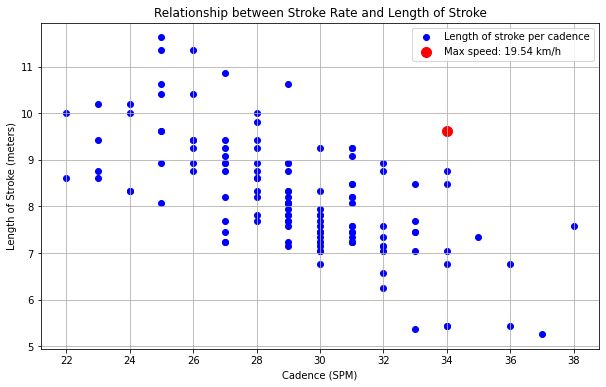

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json("Test/ergometer_500m_norm.json")

distance = 0.5 # km


# Calcul de la longueur moyenne du coup (distance parcourue / nombre de coups)
df['stroke_length'] = (distance * 1000) / df['split_stroke_count']

# Calcul de la vitesse en km/h (distance en km / temps en heures)
df['split_time_hours'] = df['split_time'] / 3600  # Conversion du temps en heures
df['speed_kmh'] = distance / df['split_time_hours']  # La distance est de 0.5 km (500m)

fastest_row = df.loc[df['speed_kmh'].idxmax()]

print(f"La vitesse maximale est de {fastest_row['speed_kmh']} km/h, atteinte à une cadence de {fastest_row['split_stroke_rate']} SPM.")



plt.figure(figsize=(10, 6))
plt.scatter(df['split_stroke_rate'], df['stroke_length'], color='blue', label='Length of stroke per cadence')

# point de cadence où la vitesse maximale est atteinte
plt.scatter(fastest_row['split_stroke_rate'], fastest_row['stroke_length'], color='red', s=100, label=f'Max speed: {fastest_row["speed_kmh"]:.2f} km/h')

plt.title('Relationship between Stroke Rate and Length of Stroke')
plt.xlabel('Cadence (SPM)')
plt.ylabel('Length of Stroke (meters)')
plt.grid()
plt.legend()

# Affichage du graphique
plt.show()


# V - Advanced
Dans ce projet, nous avons structuré notre travail en deux parties. Dans un premier temps, des visualisations interactives ont été réalisées avec **Streamlit**, accompagnées d'analyses statistiques approfondies sur un jeu de données issu d'une compétition d'ergomètres. Ces analyses ont permis de développer des modèles de prédiction pour estimer la vitesse des rameurs à différents intervalles. Vous pouvez accéder directement au jeu de données en cliquant sur le lien ci-joint: [Speed Prediction Game](https://avirondashboard.streamlit.app), ensuite, le code se trouve au répertoire `AvironDashboard`.

Dans un second temps, nous avons implémenté des algorithmes de **classification supervisée**, notamment KNN, Perceptron et arbres de décision, afin de mieux comprendre les performances des participants. En parallèle, des méthodes de **clustering non supervisé**, telles que le clustering hiérarchique et K-means, ont été appliquées pour identifier des groupes de rameurs aux caractéristiques similaires. Enfin, une analyse de la fatigue a été menée pour évaluer ses impacts potentiels sur la performance au cours de la compétition. Les codes se trouvent au répertoire `classifier`.


## Classifier
@Writer: Hoang Thuy Duong Vu

### Classification supervisée

>Code source: `classifier/supervised.ipynb`

Après l'étude des trois différents classifieurs, on obtient les résultats suivants  :

||$k$ plus proches voisins|Perceptron|Arbre de décision numérique|
|-|-|-|-|
|Training set|$33.33$|$33.33$|$100$|
|Cross Validation|$38.6 - 0.116$|$35.7 - 0.1464$|$95.7 - 0.065$|
|Test set|$50.94$|$50.94$|$100$|

En partant du tableau ci-dessus, on trouve que l'arbre de décision est le meilleur classifieur, avec l'accuracy moyenne à $95.7$ et la variance la plus basse à $0.065$. De plus, l'accuracy du classifieur en appliquant sur les bases de données d'apprentissage et de test restent $100%$. 

### Classification non-supervisée

>Code source: `classifier/unsupervised.ipynb`

Dans ce projet, on a implémenté l'algorithme de clustering hiérarchique et l'algorithme de K-moyennes. En général, les programmes marchent parfaitement sur toutes tailles de données et renvoient de bonnes résultats pour l'apprentissage non-supervisé des bases de données dans `Test` concernant la compétition des rameurs. 

Pour l'algorithme des K-moyennes, comme la version de la fonction qui calcule l'inertie n'est pas adaptée pour chaque valeur de K dans l'algorithme de K-moyennes, on va utiliser la classe `KMeans` de la librairie `sklearn.cluster`. Avec l'application de la méthode de coude, on a constaté que $k=4$ est le meilleur nombre de clusters pour effectuer les calculs des K-moyennes. 

Après l'application avec plusieurs valeurs de $k$, dont $k\in\{3,4,5,6\}$, on trouve que $k=4$ renvoit le meilleur taux d'accuracy de $0.5$, tandis que pour les autres valeurs de $k$, les taux d'accuracy varient entre $0.2$ à $0.4$.

## Analyse simple de la fatigue
@Writer: Hoang Thuy Duong Vu

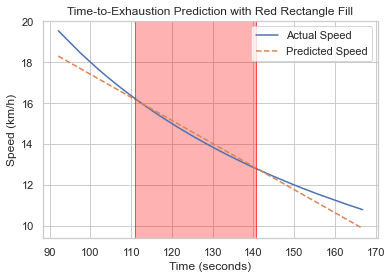

In [10]:
# Load the data
df = pd.read_json("Test/ergometer_500m.json")

df['split_time_hours'] = df['split_time'] / 3600  # Conversion du temps en heures
df['speed_kmh'] = (0.5 / df['split_time_hours'])  # La distance est de 0.5 km (500m)

X = df['split_time'].values.reshape(-1, 1) 
y = df['speed_kmh'].values 

model = LinearRegression()
model.fit(X, y)

# Predict speed over time
predicted_speed = model.predict(X)

# Convert X to a 1D array
Xp = X.flatten()  # Flatten the 2D array into 1D
arg = np.argsort(Xp)  # Sort X values
Xp_sorted = Xp[arg]
y_sorted = y[arg]
predicted_speed_sorted = predicted_speed[arg]

plt.plot(Xp_sorted, y_sorted, label='Actual Speed')
plt.plot(Xp_sorted, predicted_speed_sorted, label='Predicted Speed', linestyle='--')

intersections = np.where(np.diff(np.sign(y_sorted - predicted_speed_sorted)))[0]

if len(intersections) > 1:
    x_fill_start = Xp_sorted[intersections[0]]
    x_fill_end = Xp_sorted[intersections[1]]
    
    plt.axvline(x_fill_start, color='red', linestyle='-', linewidth=0.5)
    plt.axvline(x_fill_end, color='red', linestyle='-', linewidth=0.5)

    plt.axvspan(x_fill_start, x_fill_end, color='red', alpha=0.3)

plt.title('Time-to-Exhaustion Prediction with Red Rectangle Fill')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()

# Références
- Ghre, Johan. *AvironDashboard*. GitHub, 2024, https://github.com/JohanGhre/AvironDashboard.
- Meriadoc. *Pen-Based Recognition of Handwritten Digits*. GitHub, 2024, https://github.com/Meriadoc-gitgit/pen-based-recognition-of-handwritten-digits.
- AvironDashboard. Streamlit, 2024, https://avirondashboard.streamlit.app.

---